# Tutorial: Picket-Fence Model

In this tutorial, we will demonstrate the usage of the MoHa package to work with the Picket-Fence Richardson-Gaudin model. 
We will show that the energy levels of the Hamiltonian are evenly spaced and explore phase transitions.

## Introduction
Picket-Fence Model is a special case with equally spaced levels of the Richardson-Gaudin Model.
The Hamiltonian is given by:
$$ \hat{H}_{RG} = \sum_p (\mu_p^Z - J_{pp}^{eq}) S_p^Z + \sum_{pq} J_{pq}^{eq} S_p^+ S_q^- $$

where:
- $\mu_p^Z$ represents the Zeeman term
- $J_{pq}^{eq}$ is the equatorial interaction term
- $S_p^{\pm}$ are spin raising/lowering operators
- $S_p^Z$ is the spin projection operator

For the picket-fence model, we have:
$$ \mu_p^Z = p\Delta $$
where:
- $\Delta$ is the level spacing.

## Setup and Implementation

We will set up the Picket-Fence model with 8 sites and a level spacing of 1.0. The coupling strength $g$ will be set to 0.5.

### Step 1: Define Model Parameters
We start by defining the number of sites, level spacing, and coupling strength.

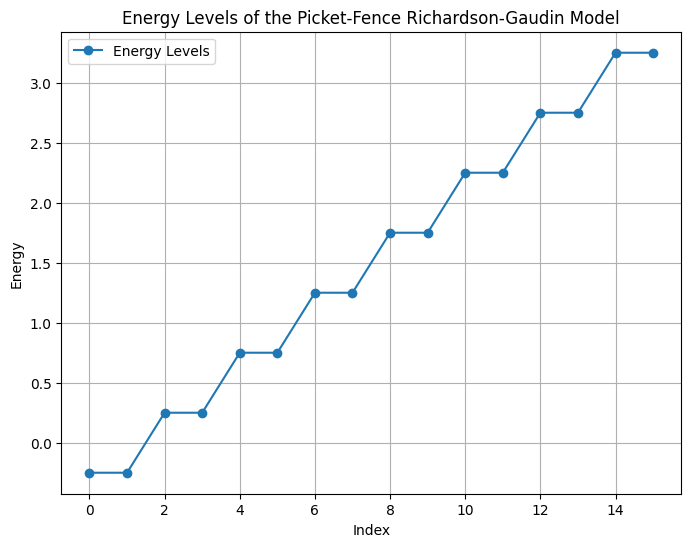

In [1]:
# Import necessary libraries
from moha import HamRG
import numpy as np
import matplotlib.pyplot as plt

# Define the Picket-Fence model parameters
n_sites = 8
level_spacing = 1.0
g = 0.5

# Generate the Zeeman term
mu = np.arange(n_sites) * level_spacing

# Create the Hamiltonian
ham = HamRG(mu=mu, J_eq=np.full((n_sites, n_sites), g))

# Generate the integrals
h = ham.generate_one_body_integral(dense=True)
v = ham.generate_two_body_integral(dense=True)

# Calculate the energy levels
eigenvals = np.linalg.eigvals(h)
eigenvals = np.sort(eigenvals)

# Plot the energy levels
plt.figure(figsize=(8, 6))
plt.plot(eigenvals, 'o-', label='Energy Levels')
plt.xlabel('Index')
plt.ylabel('Energy')
plt.title('Energy Levels of the Picket-Fence Richardson-Gaudin Model')
plt.legend()
plt.grid(True)
plt.show()

## Phase Transitions

We will now explore the phase transitions in the Picket-Fence Richardson-Gaudin model by varying the coupling strength $g$.

### Step 2: Vary Coupling Strength
We will vary the coupling strength from 0.1 to 2.0 and observe the changes in the ground state energy.

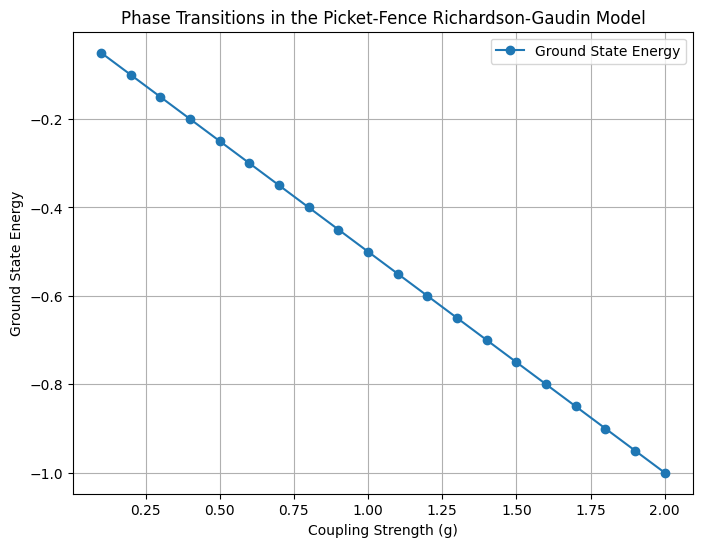

In [2]:
# Define a range of coupling strengths
g_values = np.linspace(0.1, 2.0, 20)
ground_state_energies = []

for g in g_values:
    # Update the Hamiltonian with the new coupling strength
    ham = HamRG(mu=mu, J_eq=np.full((n_sites, n_sites), g))
    h = ham.generate_one_body_integral(dense=True)
    eigenvals = np.linalg.eigvals(h)
    ground_state_energies.append(np.min(eigenvals))

# Plot the ground state energy as a function of coupling strength
plt.figure(figsize=(8, 6))
plt.plot(g_values, ground_state_energies, 'o-', label='Ground State Energy')
plt.xlabel('Coupling Strength (g)')
plt.ylabel('Ground State Energy')
plt.title('Phase Transitions in the Picket-Fence Richardson-Gaudin Model')
plt.legend()
plt.grid(True)
plt.show()